# HBR Tutorial

This tutorial will (hopefully) familiarize you with the HBR modeling functionalities that the PCNToolkit offers. We will go through the following steps:

1. What is HBR
    1. Intro to HBR
    1. An example model
1. Creating an HBR model
    1. Data preparation
    1. Fitting the model
    1. Evaluate the model
        1. Convergence
        1. Fit

By: [*Stijn de Boer*](https://nl.linkedin.com/in/stijn-de-boer-236256108)

Email: <augustijndeboer@gmail.com>.

----

This code uses the publicly available OASIS2 dataset: https://doi.org/10.1162/jocn.2009.21407, and the NKI dataset: https://doi.org/10.3389/fnins.2012.00152. 

## What is HBR?

Why to use it?



### Short intro to HBR
Hierarchical Bayesian Regression (HBR) is a method for fitting complex hierarchical models to data. When we apply HBR to Normative Modeling (NM), we model the distribution of the variable of interest as the posterior of $Y$, given $X$: $P(Y|X)$. For some simple models, the posterior has a nice analytical solution. If we want more powerful models, however, we need to approximate it by MCMC sampling.

**Reasons to use HBR**
1. Our data comes from different sites/sexes, each inducing their own batch-effects. We want the flexibility for each batch to have their own specific effects, but we also want batches to learn from eachother.
1. Our data may be very skewed or very kurtotic; curcially, non-Gaussian. Since most anlytical solutions in statistics only work when Gaussianity is assumed, they break down here.
1. We want to be able to regress any parameter on $X$
1. We want to be able to adapt and extend the model later

HBR allows us to draw samples from a posterior that:
1. Is non-Gaussian
1. Has multiple regressions on $X$
1. Has batch-effects
----

The HBR framework assumes a generative model over the response variables $Y$ in the form of a likelihood $\mathcal{L}$ plus an independent prior distribution $p$ for each parameter $\theta_i$ of the likelihood. A general model thus looks like this:
\begin{align}
    \theta_i &\sim p_{\theta_i}(\theta_i) &i \in \{1,...,P\}\\
    Y &\sim \mathcal{L}(Y|\{\theta_i | i \in \{1,...,P\}\})
\end{align}
Where $P$ is the number of parameters of the likelihood. The distribution over the parameters $\theta_i$ is approximated by MCMC sampling. Assuming the centiles of variation in the response variable are Gaussian distributed around the median, we substitute the standard Gaussian $\mathcal{N}$ for $\mathcal{L}$, and our parameters $\theta$ become the mean and variance $\mu$ and $\sigma^2$. The general model is fully capable of supporting non-Gaussian likelihoods. How we model $p_{\theta_i}$ depends on our further assumptions about the data, typically $\mu$, and optionally also $\sigma$ are taken to be linear functions of a set of covariates, which in this example are clinical or demographic variables.

### An example model
Let's conceptualize a model, and then try to build it using the PCNToolkit. We first go through the modeling decisions, and present a graphical model.

#### Nomenclature
Here the following the nomenclature is used

| Variable and type   | Thing |
|:-------|:---------|
| $N \in \mathbb{N}$| The number of observations, subjects, rows in our tables | 
| $d$ | The number of clinical covariates |
| $X \in \mathbb{R}^{N\times d}$ | Clinical covariates, here it's the *age* of the subject (so $d=1$)|
| $Y \in \mathbb{R}^{N\times 1}$ | The measure of interest, here it's the *Left-Lateral-Ventricle*|
| $B$ | The number of unique combinations of batch effects. So if we model 2 sexes and 7 sites, this will be $2\times7=14$| 
| $Z \in \mathbb{N}^{N\times 1}$ | A list of $N$ indices, corresponding to the batch effects that apply to the data. So every $z_n \in \{1,...,B\}$|
| $D$ | The dimensionality of the basis expansion|
| $\Phi\in\mathbb{R}^{N\times d\cdot D}$ | A design matrix derived from $X$. This can be a polynomial basis expansion, a b-spline basis expansion, or simply $X$. We use this design matrix for our regressions, since we may want to model nice curves, as we will see later.|

#### Modeling choices

##### Which likelihood to choose
As a first step, we need to choose an appropriate likelihood. We know that the measure of interest, the *Left-Lateral-Ventricle*, has a skewed distribution. A Gaussian likelihood is not a good choice here. We decide to use the SHASHb distribution, which is a flexible distribution parameterized by $\mu, \sigma, \epsilon, \delta$ roughly corresponding to the mean, variance, skew and kurtosis respectively. As an aside, the Gaussian is a specific case of the SHASHb distribution where $\epsilon =0$ and $\delta=1$.

The next figures show the flexibility of the SHASH distribution in modelling various distributional forms. Note the effect of the two parameters, $\epsilon$ and $\delta$.


<img src="effect-of-epsilon.png" width="300">
<img src="effect-of-delta.png" width="300">

##### Which parameters to regress on  $\Phi$
Besides that, we also know that the measure of interest tends to increase with age; it has a positive slope. Not only that, but the variance in the measure *also* tends to increase with age; as people get older, we have more uncertainty about the volume of their *Left-Lateral-Ventricle*s. From a modeling perspective, this means the variance also has a (potentially curved) slope. We decide to regress our variables controlling the mean and variance, respectively $\mu$ and $\sigma$, on $\Phi$. We could also fit a curve to the trajectories of $\epsilon$ and $\delta$, instead of keeping them fixed. This would result in a more complex model with a better fit, but it also makes more assumptions and it takes longer to fit.

##### Which basis expansion do we choose for  $\hspace{1mm}\Phi$
Furthermore, we know that these slopes are not straight lines, but rather curvy, so we choose a *bspline* basis expansion for $\Phi$.

##### How do we deal with batch-effects
Our data is derived from images from several different scanners. Each scanner has its own unique noise distribution. This causes data from some scanners to be consistently overestimated, or underestimated. Besides that, there tend to be consistent differences between male and female brains. To deal with this, we need to add a random effect to the mean for each of the batches. This random effect gives each batch (site-scanner combination) its own mean as a deviation from the group mean, i.e. the mean of all the means. 

We do not add the random effect to the variance, skew, or kurtosis parameters, since we assume them to be the same for each site and sex.

If we sample random effects, our sampler could have a hard time due to the so-called funnel effect, which is explained [here](https://twiecki.io/blog/2017/02/08/bayesian-hierchical-non-centered/). We decide to sample our random effects in a *non-centered* fashion to circumvent the funnel.

---

#### Defining the model
First, let's deal with $\epsilon$ and $\delta$, since they are simple and modeled similarly. 

Similar to $\mu$ in a Gaussian, $\epsilon$ can be any real number, and we know it is 0 for non-skewed data. We also know that it controls the skew quite severly, so we don't have to have a very wide prior. We decide to model it with a standard Gaussian

$$\epsilon \sim  \mathcal{N}(\epsilon|0,1)$$

For $\delta$, we need a positive real number, just like $\sigma$ in a Gaussian. We can model this with a Log Normal distribution. We choose our prior such that the density close to 0 is negligible, because the SHASHb distribution becomes pathological when $\delta$ is very small.

$$\delta \sim \text{LogNormal}(\delta | 1)$$

For the next parameter, $\sigma$, we decided to go for a regression without random effects. We have to find weights for the slope, and an intercept. Assuming we standardized $Y$, and we standardized $X$ before creating $\Phi$, we do not expect a very large slope, nor a very large intercept. Our slope $\mathbf{w}_\sigma$, and our intercept $b_\sigma$ can both have a standard Gaussian prior:


\begin{align}
\mathbf{w}_\sigma &\sim \mathcal{N}(\mathbf{w}_\sigma | \mathbf{0}^D, \mathbf{I}^{D\times D})\\
b_\sigma &\sim  \mathcal{N}(b_\sigma | 0, 1)
\end{align}

We do have to take care that $\sigma$ is non-negative, which we can do by applying a softplus transformation to the output of the regression. The softplus function is defined as: $\text{softplus}(x) = \log(\exp(x)+1)$, and it looks like this:

![Softplus](softplus.png)

For negative $x$, the softplus is almost 0. For positive $x$, the softplus is almost $x$. However, the softplus is smooth and differentiable, which is nice if we want to sample with NUTS later. The $\sigma$ that we find for the $n$th datapoint is then given by:

\begin{align}
\sigma_n &= \text{softplus}(\phi_n\mathbf{w}_\sigma + b_\sigma) &n\in\{1,\ldots,N\}
\end{align}


Last but not least, we need to define a $\mu_n$ for each $n\in \{1...N\}$. We decided to regress on $\Phi$, and add a random effect on the *intercept*, because the batch effects are assumed to be constant over all ages. To simplify notation, for the next paragraph, you can read $b$ as $b_\mu$, so $b_\mu$ for the $n$'th datapoint is written as $b_n$.

The intercept (with batch effect) is defined like this:
\begin{align}
\sigma_b &\sim \text{HalfCauchy}(\sigma_b|1) \\
\mu_b &\sim \mathcal{N}(\mu_b | 0, 1)\\
{\psi_b}_i &\sim \mathcal{N}({\psi_b}_i | 0, 1) &i\in\{1,...,B\}\\
b_n &= \mu_b + \sigma_b*{\psi_b}_{Z[n]} 
\end{align}

Here we see that each batch effect gets its own offset ${\psi_b}_i$ which is multiplied with $\sigma_b$. The $Z[n]$ notation indicates that the i'th batch effect is selected for the n'th datapoint by using the value of $Z[n]$.

The weight vector is sampled from a Gaussian:

$$
\mathbf{w}_\mu \sim \mathcal{N}(\mathbf{w}_\mu | \mathbf{0}^D, \mathbf{I}^{D\times D})
$$

which leads to $\mu_n$ given by:

$$\mu_n = \phi_n\mathbf{w}_\mu + b_\mu$$

Finally, we have the likelihood:

$$y_n = \text{SHASHb}(y_n | \mu_n, \sigma_n, \epsilon, \delta)$$

----

## Creating an HBR model

Now that we have a good idea of what we want, we can start coding it using the pcntoolkit.

Install necessary libraries


In [25]:
# %pip install pcntoolkit
%pip install seaborn

DEPRECATION: Loading egg at /home/stijn/.anaconda3/envs/pcn-dev-3.11/lib/python3.11/site-packages/pcntoolkit-0.3-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
Note: you may need to restart the kernel to use updated packages.


Imports

In [26]:
import os

import arviz as az
import numpy as np
import pandas as pd  # 1.4.2
import pymc as pm
import seaborn as sns  # 0.11.2
from IPython.display import display
from matplotlib import pyplot as plt  # 3.5.1

sns.set(style="darkgrid")

from pcntoolkit.dataio.norm_data import NormData
from pcntoolkit.normative_model.norm_conf import NormConf
from pcntoolkit.normative_model.norm_hbr import NormHBR
from pcntoolkit.regression_model.hbr.hbr_conf import HBRConf
from pcntoolkit.regression_model.hbr.param import Param
from pcntoolkit.normative_model.norm_factory import load_normative_model

### Data exploration and preparation
For this demo, we use the [Functional Connectome Project dataset](http://fcon_1000.projects.nitrc.org/]). This dataset contains Image Derived Phenotypes (IDPs), made by Freesurfer. The data is collected at different sites, just like we want. We create a working directory, and store our processed data there. 

In [27]:
# create working dir
tutdir = os.getcwd()
processing_dir = "HBR_tutorial_wdir/"
if not os.path.isdir(processing_dir):
    os.makedirs(processing_dir)
os.chdir(processing_dir)
processing_dir = os.getcwd()
print(f"The processing directory is: {processing_dir}")


The processing directory is: /home/stijn/Projects/PCNtoolkit-demo/tutorials/HBR_SHASH/HBR_tutorial_wdir/HBR_tutorial_wdir


In [28]:
data = pd.read_csv('https://raw.githubusercontent.com/predictive-clinical-neuroscience/PCNtoolkit-demo/main/data/fcon1000.csv')

In [29]:
covariates = ['age']
batch_effects = ['site', 'sex']
response_variables = ['Left-Lateral-Ventricle']

The phenotype we wish to model  is 'Left-Lateral-Ventricle', let's visualize it.

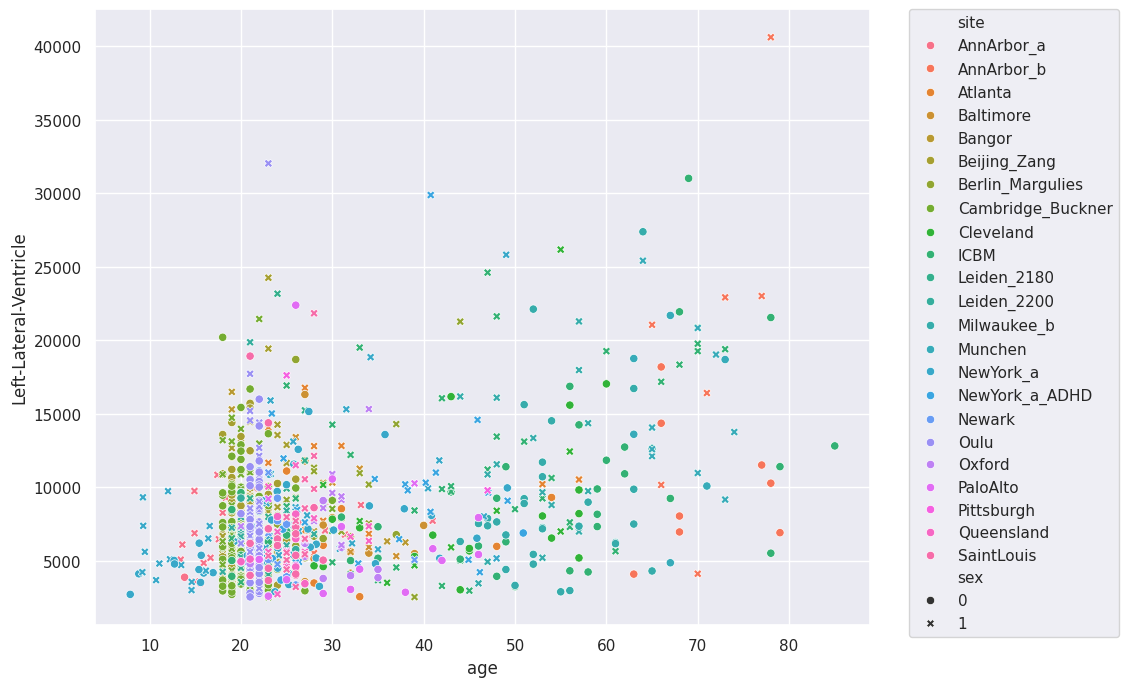

In [31]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.scatterplot(data=data, x='age', y= response_variables[0], hue='site', style='sex')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

Looks like we indeed have a bit of a skew, and an increasing mean and variance.

Let's look at the distribution of site and sex in this data.

<Axes: xlabel='count', ylabel='site'>

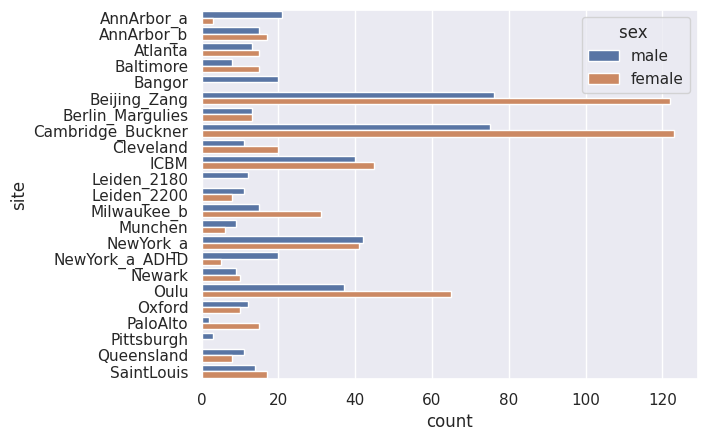

In [32]:
data['sex '] = np.where(data['sex']==1,['male'],['female'])
sns.countplot(data=data, y='site', hue='sex ', orient='v')

Our HBR models will use random effects to model differences between sites. Because the random effects are best captured when there are enough samples of each effect in the data, we will have to remove some sites that are too small. We will filter out sites for which any of the sexes is represented by less than 10 samples

<Axes: xlabel='count', ylabel='site'>

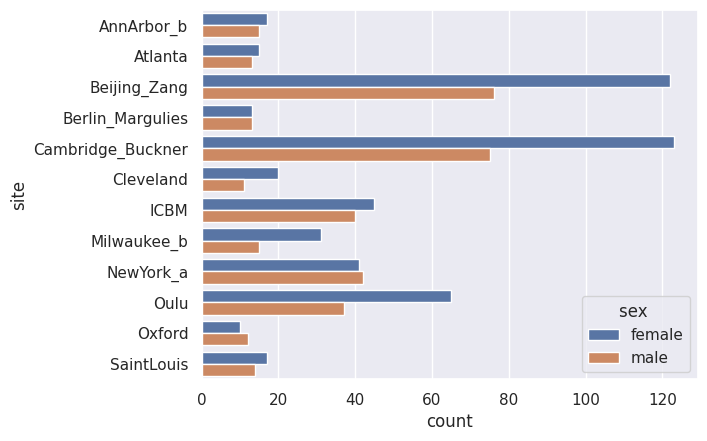

In [33]:
# Group the data by site and sex
site_counts = data.groupby(['site','sex']).size().reset_index(name='counts')

# Get the sites with only one sex present
sex_count_per_site = site_counts['site'].value_counts()
sites_with_one_sex = sex_count_per_site[sex_count_per_site==1]
sites_with_one_sex.index

# remove the sites with less than 10 samples
data = data[~data['site'].isin(sites_with_one_sex.index)]


# find the sites that have less than 10 samples
site_counts = site_counts[site_counts['counts'] < 10]

# remove the sites with less than 10 samples
data = data[~data['site'].isin(site_counts['site'])]


data['sex '] = np.where(data['sex']==1,['male'],['female'])
sns.countplot(data=data, y='site', hue='sex ', orient='v')



We load the data into NormData objects, which will take care of all the scaling, assigning ID's to batch effects, shape management, basis_expansions, and more.

In [34]:
print(batch_effects)
full_dataset = NormData.from_dataframe(name='full', dataframe=data, covariates=covariates, batch_effects=batch_effects,  response_vars=response_variables)
train_data, test_data = full_dataset.train_test_split(splits = [0.8, 0.2], split_names=['train', 'test'])

['site', 'sex']


### Creating and fitting the models

We are going to create and compare two models. The first one encodes that the left lateral ventrical volume is normally distributed conditionally on age, the second one that it follows a SHASHb distribution, which is more flexible. We will perform a model comparison at the end, to see which model will be preferred for this data. 

Model creation requires two configuration object, one for the configuration of the regression model, and one for everything else. The latter one contains the configuration of the log and save dir, the basis expansion, and the in- and outscalers. This is the `NormConf` object.

In [35]:
# normative model 1 configuration
gaussian_normconf = NormConf(
    savemodel=True,
    saveresults=True,
    log_dir=processing_dir + "/logs1",
    save_dir=processing_dir + "/model1",
    basis_function="bspline",
    basis_column=0,
    inscaler="standardize",
    outscaler="standardize",
    nknots=5,
    order=3
)

# normative model 2 configuration
shash_normconf = NormConf(
    savemodel=True,
    saveresults=True,
    log_dir=processing_dir + "/logs2",
    save_dir=processing_dir + "/model2",
    basis_function="bspline",
    basis_column=0,
    inscaler="standardize",
    outscaler="standardize",
    nknots=5,
    order=3
)

Configuration of normative model is valid.
Configuration of normative model is valid.


/home/stijn/.anaconda3/envs/pcn-dev-3.11/lib/python3.11/site-packages/pcntoolkit-0.3-py3.11.egg/pcntoolkit/normative_model/norm_conf.py:119: UserWarning: log_dir (/home/stijn/Projects/PCNtoolkit-demo/tutorials/HBR_SHASH/HBR_tutorial_wdir/HBR_tutorial_wdir/logs1) does not exist, creating it for you
  warnings.warn(
/home/stijn/.anaconda3/envs/pcn-dev-3.11/lib/python3.11/site-packages/pcntoolkit-0.3-py3.11.egg/pcntoolkit/normative_model/norm_conf.py:119: UserWarning: save_dir (/home/stijn/Projects/PCNtoolkit-demo/tutorials/HBR_SHASH/HBR_tutorial_wdir/HBR_tutorial_wdir/model1) does not exist, creating it for you
  warnings.warn(
/home/stijn/.anaconda3/envs/pcn-dev-3.11/lib/python3.11/site-packages/pcntoolkit-0.3-py3.11.egg/pcntoolkit/normative_model/norm_conf.py:119: UserWarning: log_dir (/home/stijn/Projects/PCNtoolkit-demo/tutorials/HBR_SHASH/HBR_tutorial_wdir/HBR_tutorial_wdir/logs2) does not exist, creating it for you
  warnings.warn(
/home/stijn/.anaconda3/envs/pcn-dev-3.11/lib/pytho

The second object contains all the information about the regression model. Keywords specify our modeling choices made earlier. We also have to choose our sampler configuration. Let's go for a NUTS sampler with 4 chains of 1500 sampless, and 500 tuning samples.

We create two `HBRconf` objects. For one of them, the `Param` mu has no random intercept, and for the other it has. 

In [36]:
# Normal model configuration
gaussian_conf = HBRConf(
    draws=1500,
    tune=500,
    chains=4,
    cores=16,
    likelihood="Normal",
    # Configure mu
    mu=Param(
        name="mu",
        linear=True,
        intercept=Param(
            name="intercept_mu",
            random=True,
            sigma=Param(
                name="sigma_intercept_mu", dist_name="HalfCauchy", dist_params=(1,)
            ),
        ),
    ),
    # Configure sigma
    sigma=Param(name="sigma", linear=True, mapping="softplus"),
)

# SHASHb model configuration
shash_conf = HBRConf(
    draws=1500,
    tune=500,
    chains=4,
    cores=16,
    likelihood="SHASHb",
    # Configure mu
    mu=Param(
        name="mu",
        linear=True,
        intercept=Param(
            name="intercept_mu",
            random=True,
            sigma=Param(
                name="sigma_intercept_mu", dist_name="HalfCauchy", dist_params=(1,)
            ),
        ),
    ),
    # Configure sigma
    sigma=Param(name="sigma", linear=True, mapping="softplus"),
    # Configure epsilon
    epsilon=Param(
        name="epsilon", linear=False, dist_name="Normal", dist_params=(0.0, 0.5)
    ),
    # Configure delta
    delta=Param(name="delta", linear=False, dist_name="LogNormal", dist_params=(1.0,)),
)

Configuration of regression model is valid.
Configuration of regression model is valid.


Now we create a NormHBR objects which we can fit.


In [37]:
gaussian_model = NormHBR(gaussian_normconf, gaussian_conf)
shash_model = NormHBR(shash_normconf, reg2_conf)

We can now make the call to the fit function. 

In [38]:
gaussian_model.fit(train_data)
shash_model.fit(train_data)

Going to fit 1 models
Fitting model for Left-Lateral-Ventricle


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 16 jobs)
NUTS: [slope_mu, mu_intercept_mu, sigma_intercept_mu, offset_intercept_mu, slope_sigma, intercept_sigma]


Sampling 4 chains for 500 tune and 1_500 draw iterations (2_000 + 6_000 draws total) took 94 seconds.


Going to fit 1 models
Fitting model for Left-Lateral-Ventricle


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 16 jobs)
NUTS: [slope_mu, mu_intercept_mu, sigma_intercept_mu, offset_intercept_mu, slope_sigma, intercept_sigma, epsilon, delta]


ValueError: Not enough samples to build a trace.

We save the models easily using the save function. Because the models are stored as JSON, we can also inspect them using a simple text editor.

In [ ]:
gaussian_model.save()
shash_model.save()

Saving normative model to /home/stijn/Projects/PCNtoolkit-demo/tutorials/HBR_SHASH/HBR_tutorial_wdir/model1/normative_model_dict.json
Saving normative model to /home/stijn/Projects/PCNtoolkit-demo/tutorials/HBR_SHASH/HBR_tutorial_wdir/model2/normative_model_dict.json


In [ ]:
del gaussian_model
del shash_model

gaussian_model = load_normative_model('/home/stijn/Projects/PCNtoolkit-demo/tutorials/HBR_SHASH/HBR_tutorial_wdir/model1')
shash_model = load_normative_model('/home/stijn/Projects/PCNtoolkit-demo/tutorials/HBR_SHASH/HBR_tutorial_wdir/model2')

Loading normative model from /home/stijn/Projects/PCNtoolkit-demo/tutorials/HBR_SHASH/HBR_tutorial_wdir/model1
Configuration of normative model is valid.
Configuration of regression model is valid.
Configuration of regression model is valid.
Loading normative model from /home/stijn/Projects/PCNtoolkit-demo/tutorials/HBR_SHASH/HBR_tutorial_wdir/model2
Configuration of normative model is valid.
Configuration of regression model is valid.
Configuration of regression model is valid.


### Evaluate the models

#### Summary statistics
The `az.summary()` function from the ArviZ library generates a summary of the posterior distribution for each parameter in the model. Here's what the values in the summary typically mean:

- `mean`: The mean value of the posterior distribution for the parameter.
- `sd`: The standard deviation of the posterior distribution for the parameter.
- `hdi_3%` and `hdi_97%`: The lower and upper bounds of the 94% Highest Density Interval (HDI). The HDI is the most credible interval, meaning that the true parameter value is most likely to be in this interval.
- `mcse_mean` and `mcse_sd`: The Monte Carlo Standard Error for the mean and standard deviation. This measures the amount of error in the estimate due to the finite size of the sample.
- `ess_mean`, `ess_sd`, and `ess_bulk`: The Effective Sample Size for the mean, standard deviation, and bulk. This measures the number of effectively independent draws from the posterior distribution, taking into account any autocorrelation in the Markov Chain Monte Carlo (MCMC) sampling process.
- `r_hat`: The potential scale reduction factor. This measures the convergence of the MCMC sampling process. A value close to 1 indicates that the process has converged.

The `var_names=['~samples']` argument in combination with `filter_vars=like`, is used to exclude variables that contain the word `samples` from the summary.

In [16]:
for nmi, normative_model in enumerate([gaussian_model, shash_model]):
    for response_var, model in normative_model.regression_models.items():
        print(f"Summary for nm {nmi} on {response_var}")
        display(az.summary(model.idata, var_names=['~samples'], filter_vars ='like'))


Summary for nm 0 on Left-Lateral-Ventricle


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
slope_mu[age],0.529,0.213,0.139,0.927,0.004,0.003,3634.0,4120.0,1.0
slope_mu[bspline_0],0.070,0.982,-1.669,1.993,0.010,0.014,9824.0,4263.0,1.0
slope_mu[bspline_1],-0.082,0.785,-1.568,1.335,0.014,0.010,3255.0,4074.0,1.0
slope_mu[bspline_2],0.405,0.573,-0.687,1.468,0.010,0.007,3075.0,3857.0,1.0
slope_mu[bspline_3],-0.807,0.546,-1.826,0.205,0.008,0.006,4257.0,4675.0,1.0
...,...,...,...,...,...,...,...,...,...
"intercept_mu[Oulu, 1]",0.406,0.482,-0.476,1.326,0.009,0.006,2892.0,3370.0,1.0
"intercept_mu[Oxford, 0]",-0.141,0.500,-1.066,0.813,0.009,0.006,3044.0,3681.0,1.0
"intercept_mu[Oxford, 1]",0.159,0.495,-0.774,1.074,0.009,0.006,2977.0,3719.0,1.0
"intercept_mu[SaintLouis, 0]",0.050,0.486,-0.831,0.989,0.009,0.006,2989.0,3691.0,1.0


Summary for nm 1 on Left-Lateral-Ventricle


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
slope_mu[age],0.483,0.201,0.109,0.858,0.003,0.002,4700.0,4532.0,1.0
slope_mu[bspline_0],0.108,0.971,-1.672,1.942,0.008,0.014,13459.0,4738.0,1.0
slope_mu[bspline_1],-0.271,0.746,-1.729,1.088,0.011,0.009,4268.0,4332.0,1.0
slope_mu[bspline_2],0.405,0.529,-0.608,1.383,0.008,0.006,4407.0,4215.0,1.0
slope_mu[bspline_3],-0.711,0.529,-1.705,0.262,0.007,0.005,5054.0,4859.0,1.0
...,...,...,...,...,...,...,...,...,...
"intercept_mu[Oulu, 1]",0.140,0.448,-0.663,1.001,0.007,0.005,3849.0,4320.0,1.0
"intercept_mu[Oxford, 0]",-0.020,0.452,-0.851,0.825,0.007,0.005,4016.0,4418.0,1.0
"intercept_mu[Oxford, 1]",0.122,0.455,-0.706,0.980,0.007,0.005,4032.0,4409.0,1.0
"intercept_mu[SaintLouis, 0]",0.011,0.448,-0.852,0.815,0.007,0.005,4062.0,4360.0,1.0


##### Trace plot

The trace plot helps to assess the convergence of MCMC chains. It generates two subplots for each variable:

A kernel density estimate (KDE) plot on the left, which shows the marginal posterior of each parameter. This is a smoothed version of the histogram of the sampled values.

A trace plot on the right, which shows the sampled values at each step in the chain. This plot can reveal trends or patterns in the sampling process, such as random walk behavior, long periods of stagnation, or other anomalies.


Trace plot for model 0 on Left-Lateral-Ventricle


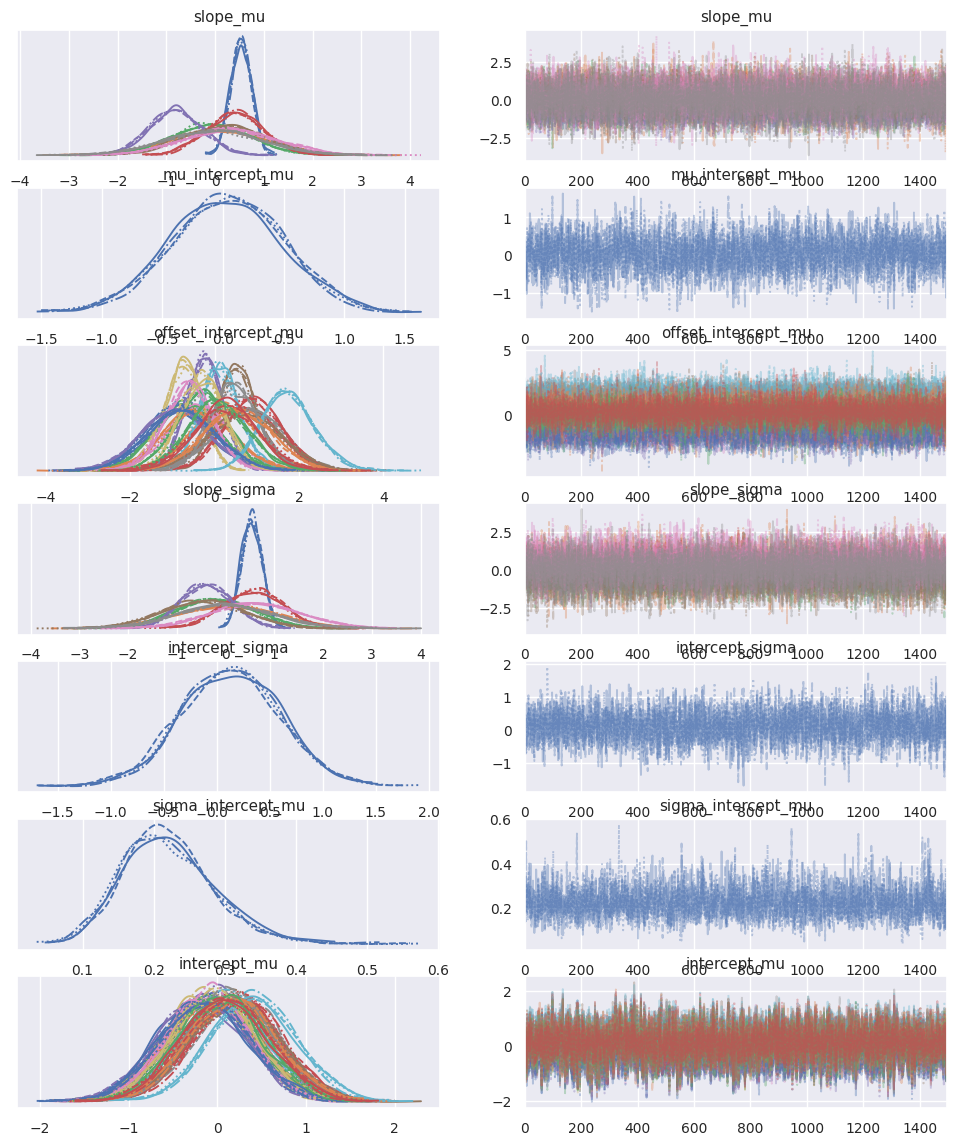

Trace plot for model 1 on Left-Lateral-Ventricle


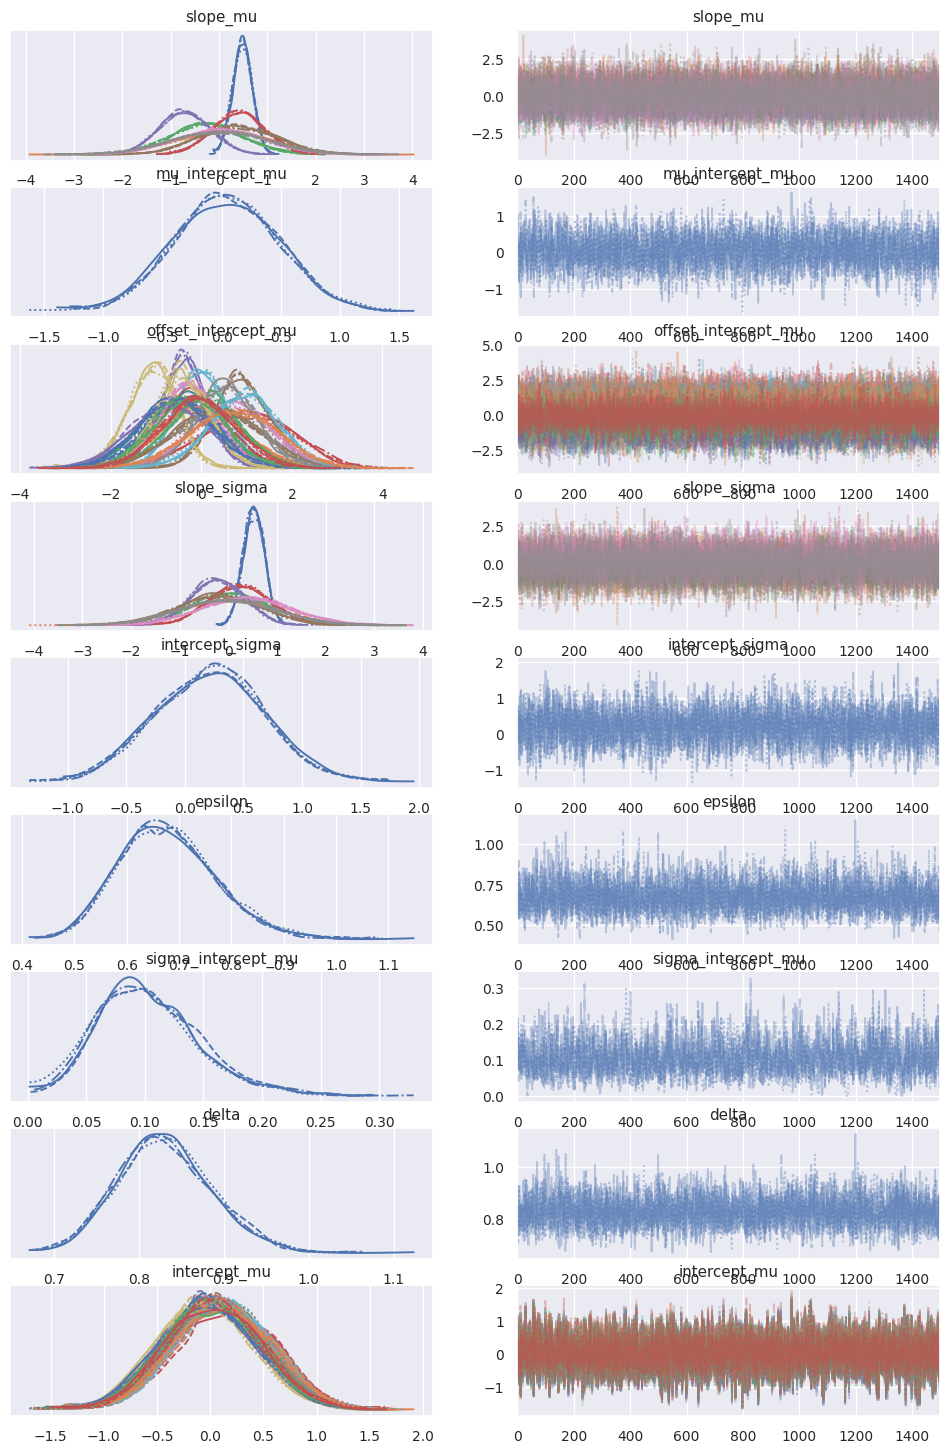

In [17]:
for nmi, normative_model in enumerate([gaussian_model, shash_model]):
    for response_var, model in normative_model.regression_models.items():
        print(f"Trace plot for model {nmi} on {response_var}")
        az.plot_trace(model.idata, var_names=['~samples'], filter_vars ='like')
        plt.show()


#### Fit

In our fit, the Rhat statistics all converge very nicely to 1. This means that all 4 chains have independently found the same distribution, which is a good indicator that it is the right one. Now that we know our samplers converge to the correct posterior, we are going to inspect the model fit. We can use our samples to get an MCMC estimate of our Z-scores, which is the most principled approach, as it accounts for the uncertainty in the model parameters. We could also use the PYMC built-in find_map function to get a MAP estimate of our parameters. Pymc3 does this quite fast, this is an estimate that is based on a single point in parameter space, whereas the MCMC estimate uses all the samples in all the chains to compute the Z-scores (or any other function) and then takes the average of all the z-scores for every datapoint. 

##### QQ-plots of the z-scores 

If we have a perfect fit, we expect the z-scores to follow a Gaussian distribution. Since the SHASHb is essentially a warped Gaussian, we can invert the warp to get the pseudo-z scores of our test data. If we sort those, and plot them against a sorted array of samples from a true Gaussian, we would like to see straight lines. 

In [18]:
test_dataset_1 = test_data.copy()
test_dataset_2 = test_data.copy()
gaussian_model.predict(test_dataset_1)
shash_model.predict(test_dataset_2)
        

Going to predict 1 models
Predicting model for Left-Lateral-Ventricle


Sampling: [y_pred]


Computing zscores for Left-Lateral-Ventricle
Computing centiles for Left-Lateral-Ventricle


Sampling: [y_pred]


/home/stijn/.anaconda3/envs/pcn-dev-3.11/lib/python3.11/site-packages/pcntoolkit-0.3-py3.11.egg/pcntoolkit/normative_model/norm_base.py:466: RuntimeWarning: invalid value encountered in log
  nll = -np.mean(y * np.log(yhat) + (1 - y) * np.log(1 - yhat))


Going to predict 1 models
Predicting model for Left-Lateral-Ventricle


Sampling: [y_pred]


Computing zscores for Left-Lateral-Ventricle


Sampling: [y_pred]


Computing centiles for Left-Lateral-Ventricle


/home/stijn/.anaconda3/envs/pcn-dev-3.11/lib/python3.11/site-packages/pcntoolkit-0.3-py3.11.egg/pcntoolkit/normative_model/norm_base.py:466: RuntimeWarning: invalid value encountered in log
  nll = -np.mean(y * np.log(yhat) + (1 - y) * np.log(1 - yhat))


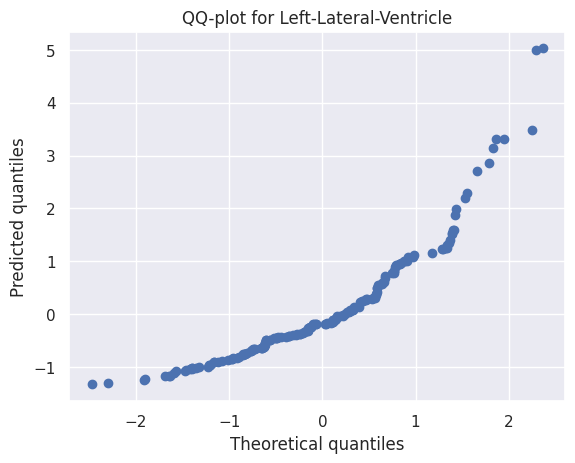

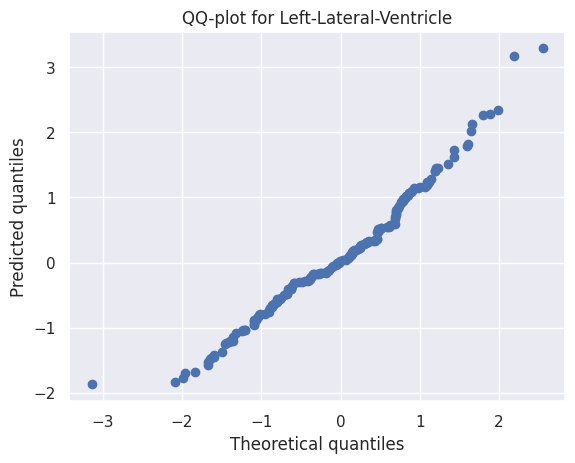

In [19]:
test_dataset_1.plot_qq()
test_dataset_2.plot_qq()

##### Quantile plots
Finally, we are ready to plot our quantiles. We hope to see that they visuallty fit the data well. 

In [20]:
synth_dataset_1 = test_dataset_1.create_synthetic_data(200,'age')
synth_dataset_2 = test_dataset_2.create_synthetic_data(200,'age')
gaussian_modelredict(synth_dataset_1)
shash_model.predict(synth_dataset_2)

Sampling: [y_pred]


Going to predict 1 models
Predicting model for Left-Lateral-Ventricle


Sampling: [y_pred]


Computing zscores for Left-Lateral-Ventricle
Computing centiles for Left-Lateral-Ventricle


/home/stijn/.anaconda3/envs/pcn-dev-3.11/lib/python3.11/site-packages/pcntoolkit-0.3-py3.11.egg/pcntoolkit/normative_model/norm_base.py:466: RuntimeWarning: invalid value encountered in log
  nll = -np.mean(y * np.log(yhat) + (1 - y) * np.log(1 - yhat))
Sampling: [y_pred]


Going to predict 1 models
Predicting model for Left-Lateral-Ventricle


Computing zscores for Left-Lateral-Ventricle


Sampling: [y_pred]


Computing centiles for Left-Lateral-Ventricle


/home/stijn/.anaconda3/envs/pcn-dev-3.11/lib/python3.11/site-packages/pcntoolkit-0.3-py3.11.egg/pcntoolkit/normative_model/norm_base.py:466: RuntimeWarning: invalid value encountered in log
  nll = -np.mean(y * np.log(yhat) + (1 - y) * np.log(1 - yhat))


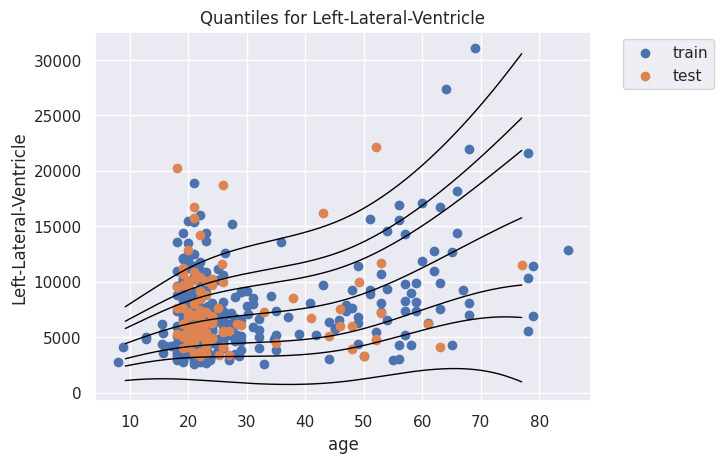

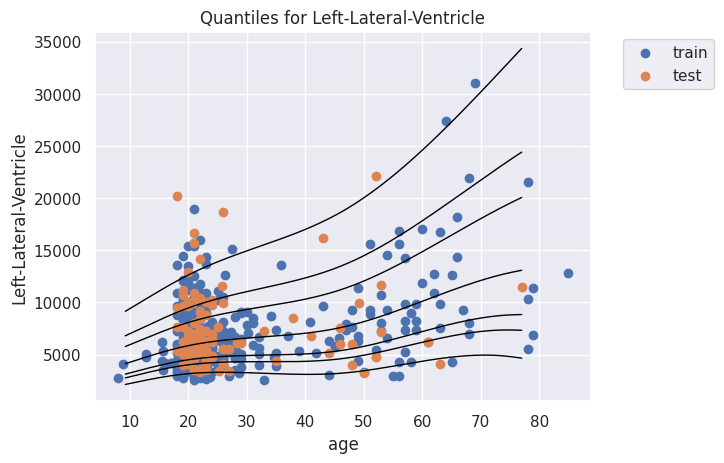

In [21]:
synth_dataset_1.plot_centiles(show_data=True, scatter_data=[train_data, test_data])
synth_dataset_2.plot_centiles(show_data=True, scatter_data=[train_data, test_data])

Looks like they fit nicely. The skew in the data, as well as the increasing mean and variance are nicely captured by the model.


### Model comparison

To do a model comparison, we can use the compare method provided by the arviz library.



In [22]:
trace1 = gaussian_model.regression_models[response_variables[0]].idata
trace2 = shash_model.regression_models[response_variables[0]].idata
with gaussian_model.regression_models[response_variables[0]].pymc_model:
    pm.compute_log_likelihood(trace1)
with shash_model.regression_models[response_variables[0]].pymc_model:
    pm.compute_log_likelihood(trace2)


model_dict = {
    'model1': trace1,
    'model2': trace2
}

comparison = az.compare(model_dict, method = 'BB-pseudo-BMA')

/home/stijn/.anaconda3/envs/pcn-dev-3.11/lib/python3.11/site-packages/arviz/stats/stats.py:802: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/stijn/.anaconda3/envs/pcn-dev-3.11/lib/python3.11/site-packages/arviz/stats/stats.py:802: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/stijn/.anaconda3/envs/

/home/stijn/.anaconda3/envs/pcn-dev-3.11/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/compareplot.py:87: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scale = comp_df["scale"][0]


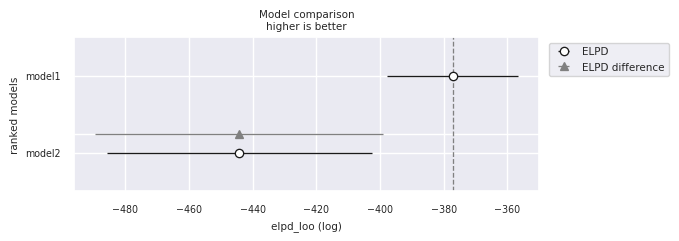

In [23]:
az.plot_compare(comparison)
plt.show()